In [2]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np

In [2]:
def eval00():
    # load dataset
    ds_nml = ds.dataset('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds_out = ds.dataset('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

    # set column
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

    # get around button pushed time
    dfl_nml = ds_nml.get_data(before=6, after=0, column=ds.list_flatten(column))
    dfl_out = ds_out.get_data(before=6, after=0, column=ds.list_flatten(column))

    # normalize
    mean_std = ds.get_mean_std(dfl_nml, column)
    dfl_nml_n = ds.normalize(dfl_nml, mean_std)
    dfl_out_n = ds.normalize(dfl_out, mean_std)
    #dfl_nml_n,ds.normalize(dfl_nml, dfl_out)

    # plot graph
    dfl_nml[1].plot()
    dfl_out[1].plot()
    dfl_nml_n[1].plot()
    dfl_out_n[1].plot()

    # calc k-NN distance
    from sklearn.neighbors import NearestNeighbors
    X_nml = [d.values.flatten() for d in dfl_nml_n]
    X_out = [d.values.flatten() for d in dfl_out_n]
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
    nbrs.fit(X_nml)

    distances, indices = nbrs.kneighbors(X_nml)
    print(distances)
    distances, indices = nbrs.kneighbors(X_out)
    print(distances)

    df_result = pd.DataFrame([[]])

path = data/raw/01_0[12]_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
extracted 3 dataframes
1 10
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


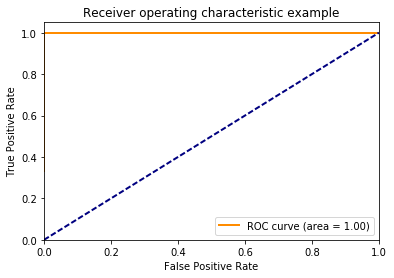

extracted 3 dataframes
extracted 3 dataframes
3 10
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


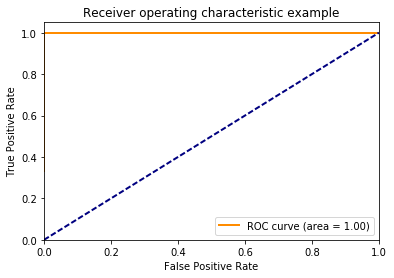

extracted 3 dataframes
extracted 3 dataframes
1 20
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


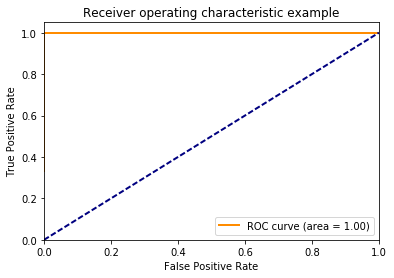

extracted 3 dataframes
extracted 3 dataframes
3 20
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


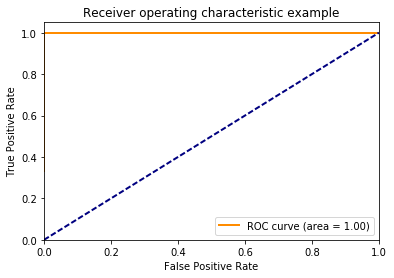

extracted 3 dataframes
extracted 3 dataframes
1 30
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


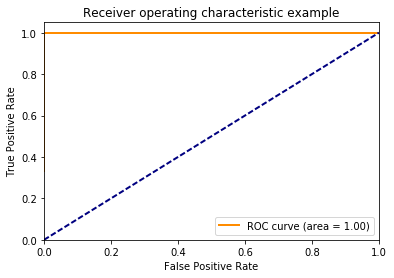

extracted 3 dataframes
extracted 3 dataframes
3 30
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


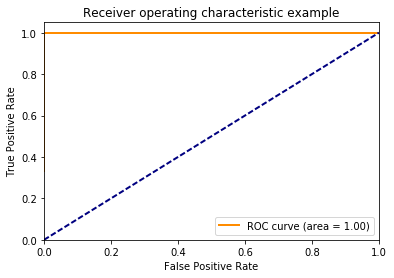

extracted 3 dataframes
extracted 3 dataframes
1 40
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


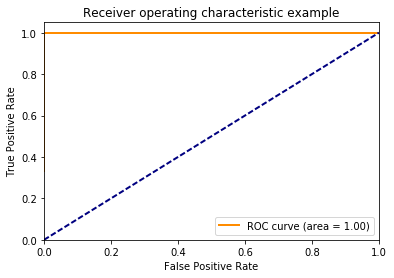

extracted 3 dataframes
extracted 3 dataframes
3 40
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


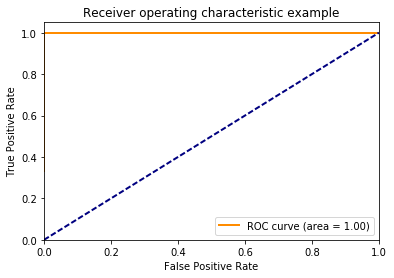

In [5]:
import estimator_knn as knn
import roc_auc

def eval01():
    ds = datasets.load('data/raw/01_0[12]_01_*')
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

    n_neighbors_range = np.arange(1, 5, 2)
    n_sample_range = np.arange(10, 50, 10)
    
    n_neighbors, n_samples = np.meshgrid(n_neighbors_range, n_sample_range)
    
    for n_neighbors, n_samples in np.c_[n_neighbors.ravel(), n_samples.ravel()]:
        data_n_2d, data_o_2d = datasets.get_normalized_data(ds,
                                                      title_n='01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
                                                      title_o ='01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
                                                      before=6, after=0, column=column)
        data_n = [d.ravel() for d in data_n_2d]
        data_o = [d.ravel() for d in data_o_2d]

        print(n_neighbors, n_samples)
        estimator = knn.EstimatorKNN(n_neighbors=n_neighbors)
        estimator.fit(data_n)
        value_n = estimator.decision_function(data_n)
        value_o = estimator.decision_function(data_o)
        
        print(value_n)
        print(value_o)
        print(np.hstack((value_n, value_o))/1000)
        print([0]*len(value_n) + [1]*len(value_o))

        roc_auc.get_auc(np.hstack((value_n, value_o))/1000, [0]*len(value_n) + [1]*len(value_o))
    

eval01()
#roc_auc.get_auc([0, 0, 0, 0.213, 0.175, 0.193], [0, 0, 0, 1, 1, 1])

In [8]:
import importlib
importlib.reload(datasets)

ImportError: module datasets not in sys.modules

In [9]:
#import estimator_knn as knn
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np

ds = datasets.load('data/raw/01_0[123]_0*_*')

path = data/raw/01_0[123]_0*_*
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x................
data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出
....................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
....................
data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出
....................
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
....................
data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅
....................
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
....................
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
....................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
....................
data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅
....................


In [32]:
import importlib
importlib.reload(datasets)

<module 'datasets' from 'datasets.ipynb'>

In [31]:
import datasets

In [40]:
import importlib
importlib.reload(roc_auc)

ImportError: module roc_auc not in sys.modules

In [42]:
import roc_auc

--- normal data ---
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
--- anomaly data ---
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
['01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅'
 '01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出'
 '01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出'
 '01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅'
 '01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅'
 '01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅']
extracted 159 dataframes


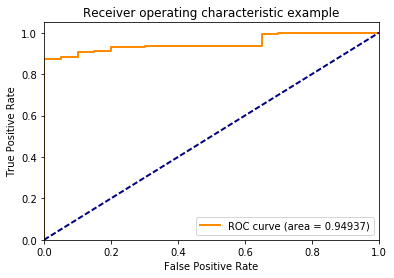

auc
0.949371069182


In [86]:
import roc_auc
import datasets
import estimator_knn as knn
import estimator_rssibased as rssie

def eval01():
    column=['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    before = 10
    base = '01_01_01'
    normal = '01_01_01'
    anomaly = '01_0[23]'
    
    print('--- normal data ---')
    data_2d_base, data_2d_n = datasets.get_normalized_data(ds,
                                                           title_base=base,
                                                           title =normal,
                                                           before=before, after=0,
                                                           column=column)
    
    print('--- anomaly data ---')
    data_2d_base, data_2d_o = datasets.get_normalized_data(ds,
                                                           title_base=base,
                                                           title =anomaly,
                                                           before=before, after=0,
                                                           column=column)
    
    width = 3
    b = np.ones(width)/width

    # smoothing data_2d_n
    new_2d_list = []
    for d2 in data_2d_n:
        n = [np.convolve(s, b)[2:-2] for s in d2.T]
        d2 = np.hstack(n).reshape(np.shape(d2)[1], -1).T
        new_2d_list.append(d2)
    data_2d_n = new_2d_list

    # smoothing data_2d_o
    new_2d_list = []
    for d2 in data_2d_o:
        n = [np.convolve(s, b)[2:-2] for s in d2.T]
        d2 = np.hstack(n).reshape(np.shape(d2)[1], -1).T
        new_2d_list.append(d2)
    data_2d_o = new_2d_list

    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = knn.EstimatorKNN()
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o)
    print('auc')
    print(auc)

eval01()

--- normal data ---
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
--- anomaly data ---
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 20 dataframes
['01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅'
 '01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出'
 '01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出'
 '01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅'
 '01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅'
 '01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅']
extracted 159 dataframes


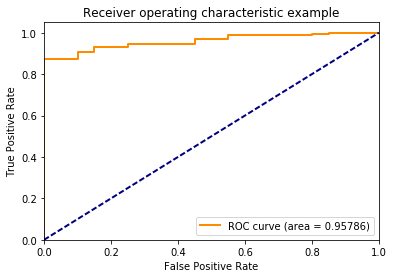

auc
0.95786163522


In [52]:
import roc_auc
import datasets
import estimator_knn as knn
import estimator_rssibased as rssie

def eval01():
    #column=['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    column=['rssi.a','rssi.b']
    before = 10
    base = '01_01_01'
    normal = '01_01_01'
    anomaly = '01_0[23]'
    
    print('--- normal data ---')
    data_2d_base, data_2d_n = datasets.get_normalized_data(ds,
                                                           title_base=base,
                                                           title =normal,
                                                           before=before, after=0,
                                                           column=column)
    
    print('--- anomaly data ---')
    data_2d_base, data_2d_o = datasets.get_normalized_data(ds,
                                                           title_base=base,
                                                           title =anomaly,
                                                           before=before, after=0,
                                                           column=column)

    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = knn.EstimatorKNN()
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o)
    print('auc')
    print(auc)

eval01()

In [83]:
a = np.arange(0,20,1)
a = a.reshape(-1,4)
print(a)

l = len(a[:,0])
o = []
width = 3
b = np.ones(width)/width
p = np.array([])
o = [np.convolve(s, b)[2:-2] for s in a.T]
    
print(l)
print(o)
print(p)
np.shape(p)
np.hstack(o).reshape(4, -1).T

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
5
[array([  4.,   8.,  12.]), array([  5.,   9.,  13.]), array([  6.,  10.,  14.]), array([  7.,  11.,  15.])]
[]


array([[  4.,   5.,   6.,   7.],
       [  8.,   9.,  10.,  11.],
       [ 12.,  13.,  14.,  15.]])